**Automated ML**

TODO: Import Dependencies. In the cell below, import all the dependencies that you will need to complete the project.

In [5]:
import logging
import os
import csv

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import pkg_resources

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset
from azureml.core import Workspace,ScriptRunConfig,Experiment, Run
from azureml.pipeline.steps import AutoMLStep

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)

SDK version: 1.19.0


**Dataset**

***Overview***

TODO: In this markdown cell, give an overview of the dataset you are using. Also mention the task you will be performing.

TODO: Get data. In the cell below, write code to access the data you will be using in this project. Remember that the dataset needs to be external.

In [6]:
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

quick-starts-ws-131566
aml-quickstarts-131566
southcentralus
61c5c3f0-6dc7-4ed9-a7f3-c704b20e3b30


**Create or Attach an AmlCompute cluster¶**

You will need to create a compute target for your AutoML run. In this tutorial, you get the default AmlCompute as your training compute resource.

Udacity Note There is no need to create a new compute target, it can re-use the previous cluster

In [7]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

# NOTE: update the cluster name to match the existing cluster
# Choose a name for your CPU cluster
amlcompute_cluster_name = "automl-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',# for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 10)
# For a more detailed view of current AmlCompute status, use get_status().

Found existing cluster, use it.
Succeeded.....................................................................................................................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


**Data**

**Udacity note:**

Make sure the key is the same name as the dataset that is uploaded, and that the description matches. If it is hard to find or unknown, loop over the ws.datasets.keys() and print() them. If it isn't found because it was deleted, it can be recreated with the link that has the CSV

In [29]:
# Try to load the dataset from the Workspace. Otherwise, create it from the file
# NOTE: update the key to match the dataset name
found = False
key = "LV_cleaned_data"
description_text = "LV hotel reviews from trip advisor"

if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

if not found:
        # Create AML Dataset and register it into Workspace
        LV_cleaned_data = 'https://raw.githubusercontent.com/Kbhamidipa3/udacityazure_capstone_final/main/LV-github-automl.csv'
        dataset = Dataset.Tabular.from_delimited_files(LV_cleaned_data)        
        #Register Dataset in Workspace
        dataset = dataset.register(workspace=ws,
                                   name=key,
                                   description=description_text)


df = dataset.to_pandas_dataframe()
config = ScriptRunConfig(source_directory='training', script='train.py', compute_target='cpu-cluster')

**Review the Dataset Result**

You can peek the result of a TabularDataset at any range using skip(i) and take(j).to_pandas_dataframe(). Doing so evaluates only j records for all the steps in the TabularDataset, which makes it fast even against large datasets.

TabularDataset objects are composed of a list of transformation steps (optional).

In [30]:
dataset.take(5).to_pandas_dataframe()

,Column1,Casino,Free_internet,Gym,Helpful_votes,Hotel_name,Hotel_stars,Member_years,Nr_hotel_reviews,Nr_reviews,...,Period_of_stay,Pool,Review_month,Review_weekday,Score,Spa,Tennis_court,Traveler_type,User_continent,User_country
0,0,True,True,True,13,Circus Circus Hotel & Casino Las Vegas,3,9,4,11,...,Dec-Feb,False,January,Thursday,1,False,False,Friends,North America,USA
1,1,True,True,True,75,Circus Circus Hotel & Casino Las Vegas,3,3,21,119,...,Dec-Feb,False,January,Friday,1,False,False,Business,North America,USA
2,2,True,True,True,25,Circus Circus Hotel & Casino Las Vegas,3,2,9,36,...,Mar-May,False,February,Saturday,1,False,False,Families,North America,USA
3,3,True,True,True,14,Circus Circus Hotel & Casino Las Vegas,3,6,7,14,...,Mar-May,False,February,Friday,1,False,False,Friends,Europe,UK
4,4,True,True,True,2,Circus Circus Hotel & Casino Las Vegas,3,7,5,5,...,Mar-May,False,March,Tuesday,1,False,False,Solo,North America,Canada


**Split into train and test data**

In [34]:
from train import clean_data
from sklearn.model_selection import train_test_split
import pandas as pd

 
#x, y = clean_data(ds)
train_data, test_data = dataset.random_split(percentage=0.75, seed=223)
x_train = train_data.to_pandas_dataframe().pop('Score')
y_train = train_data.to_pandas_dataframe().Score
x_test = test_data.to_pandas_dataframe().pop('Score')
y_test = test_data.to_pandas_dataframe().Score
data_train = pd.concat([x_train,y_train], axis=1)

os.makedirs('data_train', exist_ok=True)

local_path = './data_train/data_train.csv'
data_train.to_csv(local_path)

# upload the local file to a datastore on the cloud
workspace = Workspace(ws.subscription_id, ws.resource_group, ws.name)

# get the datastore to upload prepared data
datastore = ws.get_default_datastore()

# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir='data_train', target_path='data_train')

# create a dataset referencing the cloud location
data_train = Dataset.Tabular.from_delimited_files(path = [(datastore, ('data_train/data_train.csv'))])

Uploading an estimated of 1 files
Target already exists. Skipping upload for data_train/data_train.csv
Uploaded 0 files


**AutoML Configuration**

TODO: Explain why you chose the automl settings and cofiguration you used below.

In [35]:
automl_settings = {
    "experiment_timeout_minutes": 20,
    "max_concurrent_iterations": 5,
    "primary_metric" : 'accuracy'
}
automl_config = AutoMLConfig(compute_target=compute_target,
                             task = "classification",
                             training_data=dataset,
                             label_column_name="Score",   
                             enable_early_stopping= True,
                             featurization= 'auto',
                             debug_log = "automl_errors.log",
                             **automl_settings
                            )

**Submit your automl run**

In [33]:
experiment_name = 'lv-automl-classification'
experiment = Experiment(ws, experiment_name)
run = experiment.submit(automl_config, show_output=True)

Running on remote.
No run_configuration provided, running on automl-cluster with default configuration
Running on remote compute: automl-cluster
Parent Run ID: AutoML_4d713bd5-53de-413c-8017-184f88c4b73d

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetBalancing. Generating individually featurized CV splits.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Cross validation
STATUS:       DONE
DESCRIPTION:  Each iteration of the trained model was validated through cross-validation.
              
DETAILS:      
+---------------------------------+
|Number of folds                  |
+=================================+
|10                               |
+---------------------------------+

********************

Results
Widget for Monitoring Runs
The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

Note: The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [37]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

**Analyze results**

Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method on automl_classifier returns the best run and the fitted model for the last invocation. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

In [38]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: lv-automl-classification,
Id: AutoML_4d713bd5-53de-413c-8017-184f88c4b73d_7,
Type: azureml.scriptrun,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('SparseNormalizer',
                 <azureml.auto...
                                   colsample_bytree=0.5, eta=0.1, gamma=0,
                                   learning_rate=0.1, max_delta_step=0,
                                   max_depth=6, max_leaves=15,
                           

**Tests**

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [49]:
# convert the test data to dataframe
X_test_df = test_data.drop_columns('Score').to_pandas_dataframe()
y_test_df = test_data.keep_columns('Score', validate=True).to_pandas_dataframe()

In [50]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

**Calculate metrics for the prediction**

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values from the trained model that was returned.

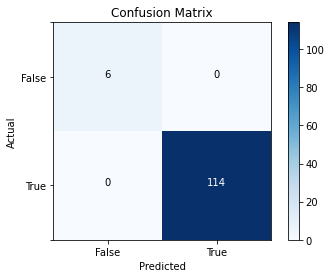

In [51]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

**Run the explanation**

Download the engineered feature importance from artifact store
You can use ExplanationClient to download the engineered feature explanations from the artifact store of the best_run. You can also use azure portal url to view the dash board visualization of the feature importance values of the engineered features.

In [53]:
from azureml.interpret import ExplanationClient
client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)
print(engineered_explanations.get_feature_importance_dict())
print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Column1_MeanImputer': 0.3648241271725998, 'Nr_reviews_MeanImputer': 0.362253986232529, 'Nr_hotel_reviews_MeanImputer': 0.2807695889819347, 'Helpful_votes_MeanImputer': 0.20964967420532163, 'User_country_HashOneHotEncoder_6': 0.20464500740659525, 'Member_years_CharGramCountVectorizer_4': 0.14085554826998292, 'Review_weekday_CharGramCountVectorizer_tuesday': 0.11970368229579677, 'Traveler_type_CharGramCountVectorizer_friends': 0.10589367616122501, 'Hotel_stars_CharGramCountVectorizer_4': 0.09691508606848731, 'Review_weekday_CharGramCountVectorizer_wednesday': 0.09118871170005315, 'Period_of_stay_CharGramCountVectorizer_jun-aug': 0.09049543745682545, 'Free_internet_ModeCatImputer_LabelEncoder': 0.0858119968690767, 'Member_years_CharGramCountVectorizer_1': 0.0715514387835813, 'Hotel_name_CharGramCountVectorizer_hilton grand vacations on the boulevard': 0.04945902716238283, 'Review_weekday_CharGramCountVectorizer_sunday': 0.04172018026866377, 'Review_weekday_CharGramCountVectorizer_saturd

**Download the raw feature importance from artifact store**

You can use ExplanationClient to download the raw feature explanations from the artifact store of the best_run. You can also use azure portal url to view the dash board visualization of the feature importance values of the raw features.

In [54]:
raw_explanations = client.download_model_explanation(raw=True)
print(raw_explanations.get_feature_importance_dict())
print("You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Column1': 0.3648241271725998, 'Nr_reviews': 0.362253986232529, 'Review_weekday': 0.3358073177559354, 'Nr_hotel_reviews': 0.2807695889819347, 'Member_years': 0.2637632782510997, 'User_country': 0.21551010893533815, 'Helpful_votes': 0.20964967420532163, 'Period_of_stay': 0.17823756284125336, 'Traveler_type': 0.16130540176773261, 'Review_month': 0.15521085316285438, 'Hotel_stars': 0.1382488719948604, 'Hotel_name': 0.12186312436355967, 'User_continent': 0.09015368775925177, 'Free_internet': 0.0858119968690767, 'Spa': 0.012417544585362712, 'Tennis_court': 0.008518805656292403, 'Casino': 0.004239156784423768, 'Pool': 0.0, 'Nr_rooms': 0.0, 'Gym': 0.0}
You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-
https://ml.azure.com/experiments/lv-automl-classification/runs/AutoML_4d713bd5-53de-413c-8017-184f88c4b73d_7?wsid=/subscriptions/61c5c3f0-6dc7-4ed9-a7f3-c704b20e3b30/resourcegroups/aml-quickstarts-131566/workspaces/quick-starts-ws-131566


**Retrieve any other AutoML model from training**

In [80]:
best_run, fitted_model = run.get_output(metric='accuracy')

**Setup the model explanations for AutoML models**

The fitted_model can generate the following which will be used for getting the engineered explanations using automl_setup_model_explanations:-

Featurized data from train samples/test samples
Gather engineered name lists
Find the classes in your labeled column in classification scenarios
The automl_explainer_setup_obj contains all the structures from above list.

In [81]:
X_train = train_data.drop_columns('Score')
y_train = train_data.keep_columns('Score', validate=True)
X_test = test_data.drop_columns('Score')

In [82]:
from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations

automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X=X_train, 
                                                             X_test=X_test, y=y_train, 
                                                             task='classification')

Current status: Setting up data for AutoML explanations
Current status: Setting up the AutoML featurizer
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurization for explanations
Current status: Using 120 evaluation samples
Current status: Generating a feature map for raw feature importance
Current status: Finding all classes from the dataset
Current status: Choosing the surrogate model as LightGBM for the AutoML model
Current status: Data for AutoML explanations successfully setup


**Initialize the Mimic Explainer for feature importance**

For explaining the AutoML models, use the MimicWrapper from azureml-interpret package. The MimicWrapper can be initialized with fields in automl_explainer_setup_obj, your workspace and a surrogate model to explain the AutoML model (fitted_model here). The MimicWrapper also takes the automl_run object where engineered explanations will be uploaded.

In [83]:
from interpret.ext.glassbox import LGBMExplainableModel
from azureml.interpret.mimic_wrapper import MimicWrapper
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator,
                         explainable_model=automl_explainer_setup_obj.surrogate_model, 
                         init_dataset=automl_explainer_setup_obj.X_transform, run=best_run,
                         features=automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps=[automl_explainer_setup_obj.feature_map],
                         classes=automl_explainer_setup_obj.classes,
                         explainer_kwargs=automl_explainer_setup_obj.surrogate_model_params)

**Use Mimic Explainer for computing and visualizing engineered feature importance**

The explain() method in MimicWrapper can be called with the transformed test samples to get the feature importance for the generated engineered features. You can also use azure portal url to view the dash board visualization of the feature importance values of the engineered features.

In [84]:
# Compute the engineered explanations
engineered_explanations = explainer.explain(['local', 'global'], eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(engineered_explanations.get_feature_importance_dict())
print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Column1_MeanImputer': 0.4418421054616747, 'Nr_reviews_MeanImputer': 0.3345093912494768, 'Nr_hotel_reviews_MeanImputer': 0.21810087780360687, 'Helpful_votes_MeanImputer': 0.18458618345760786, 'User_country_HashOneHotEncoder_6': 0.1506764866474985, 'Member_years_CharGramCountVectorizer_4': 0.14743931855369846, 'Tennis_court_ModeCatImputer_LabelEncoder': 0.14356855672975655, 'Review_weekday_CharGramCountVectorizer_tuesday': 0.13805554173016332, 'Hotel_stars_CharGramCountVectorizer_4': 0.10434258003724774, 'Hotel_stars_CharGramCountVectorizer_5': 0.10356821909465849, 'Traveler_type_CharGramCountVectorizer_friends': 0.09818243798208622, 'Member_years_CharGramCountVectorizer_1': 0.09106726638534644, 'Review_weekday_CharGramCountVectorizer_friday': 0.07098059031700374, 'Review_weekday_CharGramCountVectorizer_wednesday': 0.06542311382230055, 'Review_month_CharGramCountVectorizer_january': 0.06416521403062554, 'Review_month_CharGramCountVectorizer_april': 0.05406351260357005, 'Period_of_stay_

**Use Mimic Explainer for computing and visualizing raw feature importance**

The explain() method in MimicWrapper can be called with the transformed test samples to get the feature importance for the original features in your data. You can also use azure portal url to view the dash board visualization of the feature importance values of the original/raw features.

In [85]:
# Compute the raw explanations
raw_explanations = explainer.explain(['local', 'global'], get_raw=True,
                                     raw_feature_names=automl_explainer_setup_obj.raw_feature_names,
                                     eval_dataset=automl_explainer_setup_obj.X_test_transform,
                                     raw_eval_dataset=automl_explainer_setup_obj.X_test_raw)
print(raw_explanations.get_feature_importance_dict())
print("You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + best_run.get_portal_url())

{'Column1': 0.4418421054616747, 'Review_weekday': 0.39722012215972924, 'Nr_reviews': 0.3345093912494768, 'Member_years': 0.28767579680374583, 'Nr_hotel_reviews': 0.21810087780360687, 'Hotel_stars': 0.21302906928097062, 'Review_month': 0.21090724550023254, 'User_country': 0.2006624723940379, 'Helpful_votes': 0.18458618345760786, 'Traveler_type': 0.1781832756920504, 'Tennis_court': 0.14356855672975655, 'Period_of_stay': 0.1383859332917754, 'User_continent': 0.055020184104073555, 'Spa': 0.04617704980336347, 'Hotel_name': 0.004871932286015015, 'Nr_rooms': 0.0, 'Pool': 0.0, 'Gym': 0.0, 'Free_internet': 0.0, 'Casino': 0.0}
You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-
https://ml.azure.com/experiments/lv-automl-classification/runs/AutoML_4d713bd5-53de-413c-8017-184f88c4b73d_7?wsid=/subscriptions/61c5c3f0-6dc7-4ed9-a7f3-c704b20e3b30/resourcegroups/aml-quickstarts-131566/workspaces/quick-starts-ws-131566


**Initialize the scoring Explainer, save and upload it for later use in scoring explanation**

In [91]:
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer
import joblib

# Initialize the ScoringExplainer
scoring_explainer = TreeScoringExplainer(explainer.explainer, feature_maps=[automl_explainer_setup_obj.feature_map])

# Pickle scoring explainer locally to './scoring_explainer.pkl'
scoring_explainer_file_name = 'scoring_explainer.pkl'
with open(scoring_explainer_file_name, 'wb') as stream:
    joblib.dump(scoring_explainer, stream)

# Register trained automl model present in the 'outputs' folder in the artifacts
#original_model = best_run.register_model(model_name='lv-automl-classification',model_path='outputs/model.pkl')
    
original_model = best_run.register_model(model_name='lv-automl-classification', 
                                           model_path='outputs/model.pkl')

# Upload the scoring explainer to the automl run
#best_run.upload_file('outputs/scoring_explainer.pkl', scoring_explainer_file_name)
scoring_explainer_model = best_run.register_model(model_name='scoring_explainer', model_path='outputs/scoring_explainer.pkl')

**Create the conda dependencies for setting up the service**

In [92]:
from azureml.core.conda_dependencies import CondaDependencies

azureml_pip_packages = [
    'azureml-interpret', 'azureml-train-automl', 'azureml-defaults'
]

myenv = CondaDependencies.create(conda_packages=['scikit-learn', 'pandas', 'numpy', 'py-xgboost<=0.80'],
                                 pip_packages=azureml_pip_packages,
                                 pin_sdk_version=True)

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-interpret~=1.19.0
  - azureml-train-automl~=1.19.0
  - azureml-defaults~=1.19.0
- scikit-learn
- pandas
- numpy
- py-xgboost<=0.80
channels:
- anaconda
- conda-forge



In [122]:
import os
path = os.getcwd()
os.listdir(path)
path

import logging
logging.basicConfig(level=logging.DEBUG)
print(Model.get_model_path(model_name='scoring_explainer_model'))

ModelNotFoundException: ModelNotFoundException:
	Message: Model scoring_explainer_model not found in cache at azureml-models or in current working directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-lv/code/Users/odl_user_131566. For more info, set logging level to DEBUG.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Model scoring_explainer_model not found in cache at azureml-models or in current working directory /mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-lv/code/Users/odl_user_131566. For more info, set logging level to DEBUG."
    }
}

**Deploy the service**

In [119]:
from azureml.core.webservice import Webservice
from azureml.core.webservice import AciWebservice
from azureml.core.model import Model, InferenceConfig
from azureml.core.environment import Environment

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1,
                                               memory_gb=1,
                                               auth_enabled=True,
                                               enable_app_insights=True,
                                               tags={"data": "LV_cleaned_data",  
                                                     "method" : "local_explanation"})


myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(entry_script='outputs/scoring_file_v_1_0_0.py', environment=myenv)

# Use configs and models generated above
aci_service = Model.deploy(ws,
                       'modeling-score',
                       [scoring_explainer_model, original_model],
                       inference_config,
                       aciconfig)
service.wait_for_deployment(show_output=True)
aci_service.regen_key("Primary")
# or
aci_service.regen_key("Secondary")
print(aci_service.get_logs())

WebserviceException: WebserviceException:
	Message: Service modeling-score with the same name already exists, please use a different service name or delete the existing service.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Service modeling-score with the same name already exists, please use a different service name or delete the existing service."
    }
}

**View the service logs**

In [ ]:
aci_service.get_logs()

**Inference with test data**

In [ ]:
if service.state == 'Healthy':
    # Serialize the first row of the test data into json
    X_test_json = X_test[:1].to_json(orient='records')
    print(X_test_json)
    # Call the service to get the predictions and the engineered explanations
    output = service.run(X_test_json)
    # Print the predicted value
    print(output['predictions'])
    # Print the engineered feature importances for the predicted value
    print(output['engineered_local_importance_values'])

**Delete the service.**

In [ ]:
#service.delete()

**Delete the cluster at the end of the run**

In [ ]:
#cpu_cluster.delete()